Data de entrega: 31/07/2022
_________

Grupo:
- Ana Paula
- Maeba Tomaselli
- Nicolas

# Projeto módulo ML I ML II e MLIII - Crédito para Financiamento de Imóveis


____________


## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **bons pagadores** dos **maus pagadores**. 

Para isso, foi disponibilizada uma base de dados com milhares de casos de **empréstimos do passado** com diversas características dos clientes. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC** (mas isso é flexível, conforme detalhado mais abaixo!)


## Base de Dados

Serão utilizadas bases de dados com **informações cadastrais, histórico de crédito e balanços financeiros de diversos clientes**. 

O conjunto de dados está dividido em **treino e teste**, todos no formato csv. 

Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de **treino**, que contém o target (arquivo: `aplication_train.csv`)

Há uma base já pronta, mas as demais bases auxiliares também serão disponibilizadas (sintam-se à vontade para explorá-las e utilizar as informações que julgarem relevantes!)

[Clique aqui](https://drive.google.com/file/d/17fyteuN2MdGdbP5_Xq_sySN_yH91vTup/view) pra baixar os dados (eles estão disponiveis no arquivo zipado `credito-imoveis.zip`).

## Objetivo: para quem liberar o crédito?

### Classificar tipos de crédito

## Regras de Entrega

Deve ser entregue um arquivo csv com as **predições** para a base de teste.

Essa base deverá ser um Data Frame com duas colunas: a primeira sendo o **SK_ID_CURR** e a segunda a **probabilidade de inadimplência.**

### IMPORTANTE!

Entregar as predições com a **probabilidade da inadimplência ocorrer**, não a classe predita (pois eu irei calcular a AUC de teste, com os targets que eu tenho disponível ;D (mas depois vou compartilhar com vcs tbm!))

Além do arquivo com as predições, claro, entreguem também o notebook com o código utilizado. É importante que ele tenha:

- (i) a análise exploratória e construção das variáveis explicativas;

- (ii) a análise de modelagem, mostrando o processo das avaliações dos modelos e os motivos das decisões tomadas sobre qual modelo usar.

## Dicas


Explorar o conceito das variáveis: existe risco de imagem uma empresa utilizar variável de sexo para determinar risco de crédito? Vale a pena trazer a variável para o modelo?

Criar novas variáveis usando as variáveis que já estão na base: criatividade!

Qualquer dúvida, só me chamar! ;)


<br>

<br>

# Parte 1 - Exploração inicial dos dados

In [1]:
#Carregando bibliotecas de exploração
import pandas as pd
import numpy as np
from scipy import stats

#Carregando bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

#Carregando biblioteca de regularização
from sklearn.linear_model import Lasso

#Carregando bibliotecas para o preprocessamento dos dados
from sklearn.preprocessing import StandardScaler, OneHotEncoder  #, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#Carregando bibliotecas de balanceamento de dados
from imblearn.over_sampling import SMOTE

#Carregando bibliotecas dos modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Carregando bibliotecas de avaliação dos modelos
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Carregando as bases de dados

In [2]:
def carrega_dataset(arquivo, index_col=None, encoding='UTF-8'):
    '''
    Função para carregar as tabelas e transformá-las em datasets
    
    args:
    - arquivo: nome do arquivo;
    - index_col: None se não for aplicável e 0 se transformar a primeira coluna em índice;
    - encoding: UTF-8 por padrão e codificação diferente quando necessário
    
    return:
    - df: dataset carregado
    '''

    #Dados para acessar o caminho do arquivo e usar a codificação
    path = 'datasets/dados_projeto'

    caminho_completo = '../' + path + '/' + arquivo

    df = pd.read_csv(caminho_completo, encoding=encoding, index_col=index_col)

    return df

In [3]:
#Nomes dos arquivos
application_train = 'application_train.csv'
home_credit_col = 'HomeCredit_columns_description.csv'

In [4]:
#Carregando os dados do application_train - tabela principal - treino
df_application_train = carrega_dataset(arquivo=application_train)
df_application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [5]:
#Carregando os dados do HomeCredit_columns - contém a descrição das colunas de todas as tabelas do projeto
df_home_credit_col = carrega_dataset(arquivo=home_credit_col, index_col=0, encoding='latin1')
df_home_credit_col

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [6]:
#df_application_test = pd.read_csv('../datasets/dados_projeto/application_test_student.csv')
#df_bureau = pd.read_csv('../datasets/dados_projeto/bureau.csv')
#df_bureau_bal = pd.read_csv('../datasets/dados_projeto/bureau_balance.csv')
#df_credit_card_bal = pd.read_csv('../datasets/dados_projeto/credit_card_balance.csv')
#df_installments_pay = pd.read_csv('../datasets/dados_projeto/installments_payments.csv')
#df_pos_cash = pd.read_csv('../datasets/dados_projeto/POS_CASH_balance.csv')
#df_pre_applicaion = pd.read_csv('../datasets/dados_projeto/previous_application.csv')
#df_sample_submission = pd.read_csv('../datasets/dados_projeto/sample_submission.csv')

<br>

## Explorando os dados da tabela principal

### Conhecendo a tabela principal

In [7]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [8]:
df_application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 229.0+ MB


In [9]:
#Quantidade de memória utilizada pela base de dados
df_application_train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 429.3 MB


Devido ao tamanho do arquivo é preciso colocar alguns parâmetros no info para apresentar todo conteúdo.

In [10]:
df_application_train.info(verbose=1, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    246008 non-null  int64  
 1    TARGET                        246008 non-null  int64  
 2    NAME_CONTRACT_TYPE            246008 non-null  object 
 3    CODE_GENDER                   246008 non-null  object 
 4    FLAG_OWN_CAR                  246008 non-null  object 
 5    FLAG_OWN_REALTY               246008 non-null  object 
 6    CNT_CHILDREN                  246008 non-null  int64  
 7    AMT_INCOME_TOTAL              246008 non-null  float64
 8    AMT_CREDIT                    246008 non-null  float64
 9    AMT_ANNUITY                   245998 non-null  float64
 10   AMT_GOODS_PRICE               245782 non-null  float64
 11   NAME_TYPE_SUITE               244960 non-null  object 
 12   NAME_INCOME_TYPE            

### Avaliando quantas colunas numéricas e quantas colunas categóricas

In [11]:
df_application_train.select_dtypes(include='number').shape

(246008, 106)

In [12]:
df_application_train.select_dtypes(include='object').shape

(246008, 16)

#### Quais colunas são categóricas? É preciso transformá-las em numéricas?

In [13]:
df_application_train.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

### Conhecendo o conteúdo das colunas categóricas

In [14]:
df_application_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         222622
Revolving loans     23386
Name: NAME_CONTRACT_TYPE, dtype: int64

In [15]:
df_application_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      198726
Family              32145
Spouse, partner      9121
Children             2614
Other_B              1448
Other_A               689
Group of people       217
Name: NAME_TYPE_SUITE, dtype: int64

In [16]:
df_application_train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    174831
Higher education                  59832
Incomplete higher                  8208
Lower secondary                    3004
Academic degree                     133
Name: NAME_EDUCATION_TYPE, dtype: int64

In [17]:
df_application_train['NAME_INCOME_TYPE'].value_counts()

Working                 126919
Commercial associate     57321
Pensioner                44389
State servant            17337
Unemployed                  17
Student                     12
Businessman                 10
Maternity leave              3
Name: NAME_INCOME_TYPE, dtype: int64

In [18]:
df_application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 157074
Single / not married     36395
Civil marriage           23798
Separated                15868
Widow                    12872
Unknown                      1
Name: NAME_FAMILY_STATUS, dtype: int64

In [19]:
df_application_train['NAME_HOUSING_TYPE'].value_counts()

House / apartment      218258
With parents            11917
Municipal apartment      8922
Rented apartment         3889
Office apartment         2109
Co-op apartment           913
Name: NAME_HOUSING_TYPE, dtype: int64

In [20]:
df_application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 44126
Sales staff              25721
Core staff               21868
Managers                 17001
Drivers                  14973
High skill tech staff     9105
Accountants               7901
Medicine staff            6823
Security staff            5371
Cooking staff             4723
Cleaning staff            3708
Private service staff     2122
Low-skill Laborers        1698
Waiters/barmen staff      1084
Secretaries               1052
Realty agents              618
HR staff                   442
IT staff                   435
Name: OCCUPATION_TYPE, dtype: int64

In [21]:
df_application_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    54495
XNA                       44399
Self-employed             30722
Other                     13350
Medicine                   8982
Business Entity Type 2     8433
Government                 8330
School                     7078
Trade: type 7              6258
Kindergarten               5448
Construction               5389
Business Entity Type 1     4859
Transport: type 4          4277
Trade: type 3              2767
Industry: type 9           2695
Industry: type 3           2627
Security                   2594
Housing                    2368
Industry: type 11          2138
Military                   2114
Bank                       1980
Agriculture                1960
Police                     1866
Transport: type 2          1745
Postal                     1719
Security Ministries        1565
Trade: type 2              1506
Restaurant                 1478
Services                   1264
University                 1057
Industry: type 7           1037
Transpor

In [22]:
df_application_train['FONDKAPREMONT_MODE'].value_counts()

reg oper account         58983
reg oper spec account     9645
not specified             4536
org spec account          4452
Name: FONDKAPREMONT_MODE, dtype: int64

In [23]:
df_application_train['HOUSETYPE_MODE'].value_counts()

block of flats      120287
specific housing      1212
terraced house         969
Name: HOUSETYPE_MODE, dtype: int64

In [24]:
df_application_train['EMERGENCYSTATE_MODE'].value_counts()

No     127375
Yes      1872
Name: EMERGENCYSTATE_MODE, dtype: int64

**Manter as colunas e transformá-las em numéricas:**<br>
- NAME_CONTRACT_TYPE - tipo de empréstimo - importante;
- FLAG_OWN_CAR, FLAG_OWN_REALTY - se o cliente possui carro - importante, pode ser uma garantia;
- NAME_INCOME_TYPE - tipo de renda do cliente - importante;
- NAME_FAMILY_STATUS - status civil, pode ser importante;
- NAME_HOUSING_TYPE - moradia atual, importante;
- OCCUPATION_TYPE - tipo de ocupação profissional do cliente, importante;
- ORGANIZATION_TYPE - tipo de organização onde o cliente trabalha, possivelmente manter;
- FONDKAPREMONT_MODE?
- HOUSETYPE_MODE?
- EMERGENCYSTATE_MODE.

**Possibilidade de excluir as colunas:**
- CODE_GENDER - possivelmente excluir, avaliação nos próximos itens;
- NAME_TYPE_SUITE - possivelmente excluir, avaliação nos próximos itens;<br>
- NAME_EDUCATION_TYPE - nível educacional do cliente, possivelmente excluir, enviesar o modelo, testar antes;
- WEEKDAY_APPR_PROCESS_START - qual dia da semana o cliente solicitou o empréstimo, possivelmente excluir;
- WALLSMATERIAL_MODE - tipo de material da casa, excluir, avaliação nos próximos itens (nulos).

### Avaliando as métricas das colunas

In [25]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,246008.000000,246008.000000,246008.000000,2.460080e+05,2.460080e+05,245998.000000,2.457820e+05,246008.000000,246008.000000,246008.000000,...,246008.000000,246008.000000,246008.000000,246008.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000
mean,278280.072908,0.081176,0.415527,1.689122e+05,5.996283e+05,27129.162648,5.389289e+05,0.020882,-16042.794393,63963.755699,...,0.007975,0.000589,0.000508,0.000289,0.006291,0.006944,0.034487,0.267403,0.264109,1.900040
std,102790.909988,0.273106,0.719922,2.603818e+05,4.030672e+05,14504.965232,3.699738e+05,0.013852,4365.973763,141400.318322,...,0.088948,0.024271,0.022536,0.016986,0.083236,0.109538,0.204179,0.916640,0.611269,1.868217
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189165.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16561.125000,2.385000e+05,0.010006,-19691.000000,-2758.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278392.500000,0.000000,0.000000,1.485000e+05,5.147775e+05,24930.000000,4.500000e+05,0.018850,-15763.000000,-1215.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367272.250000,0.000000,1.000000,2.025000e+05,8.086500e+05,34599.375000,6.795000e+05,0.028663,-12418.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,19.000000,23.000000


A quantidade de colunas numéricas dificulta a visualização e análise direta dos dados.

### Avaliando a coluna ID para transformá-la em index (se possível)

In [26]:
#Verificando se a primeira coluna tem somente valores únicos que podem ser utilizados como índice
df_application_train['SK_ID_CURR'].nunique()

246008

É possível transformar a primeira coluna em index e isso deve ser feito posteriormente e aplicado nas bases de treino e teste.

### Explorando as colunas

In [27]:
df_application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

Total de 121 colunas

In [28]:
df_application_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [29]:
#Avaliando quantidade de colunas com dados faltantes
nulos = df_application_train.isna().sum()
nulos = nulos[nulos > 0]
nulos.count()

67

Existem muitas coluans com dados nulos, será necessário tratar essas colunas ou excluí-las.

### Tabela explicativa das colunas

In [30]:
df_home_credit_col

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [31]:
#Quantas linhas podem ser mostradas
pd.get_option('display.max_rows')

60

In [32]:
#Aumentando a quantidade de linhas que podem ser visualizadas (duas formas apresentadas abaixo)
#pd.set_option('display.max_rows', 122)
pd.options.display.max_rows = 122

In [33]:
#Quantas linhas podem ser mostradas
pd.get_option('display.max_rows')

122

In [34]:
df_home_credit_col[df_home_credit_col['Table'] ==
                   'application_{train|test}.csv']

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [35]:
#Acessando o conteúdo que explica a variável target
df_home_credit_col[
    (df_home_credit_col['Table'] == 'application_{train|test}.csv')
    & (df_home_credit_col['Row'] == 'TARGET')]

,Table,Row,Description,Special
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN


In [36]:
#Como ainda não foi possível ler todo o conteúdo, mostra-se especificamente a célula com a descrição
df_home_credit_col[
    (df_home_credit_col['Table'] == 'application_{train|test}.csv')
    & (df_home_credit_col['Row'] == 'TARGET')]['Description']

2    Target variable (1 - client with payment diffi...
Name: Description, dtype: object

**TARGET:**
- 1: cliente como dificuldades de pagamento: pagamento atrasado por mais de X dias em Y parcelas do empréstimo considerando a amostra;
- 0: todos os outros casos.

### Conclusão da exploração das colunas

**Total:**
- 122 colunas
- 246.008 linhas

**Numéricas:**
- 106 colunas

**Categóricas:**
- 16 colunas

**Colunas com dados faltantes:**
- 67 colunas

**Avaliar exclusão das colunas abaixo:**
- Colunas com mais de 40% dos dados faltando;
- Gênero (CODE_GENDER);
- NAME_TYPE_SUITE (quem estava acompanhando o cliente);
- FLAG_MOBIL (se o cliente passou o celular);
- FLAG_EMP_PHONE (se o cliente passou o telefone residencial);
- FLAG_WORK_PHONE (se o cliente passou o telefone do trabalho);
- FLAG_PHONE (se o cliente passou o telefone residencial).

### Avaliando algumas colunas

#### Gênero

A avaliação por gênero pode gerar um enviesamento sexista ao modelo.

In [37]:
df_application_train['CODE_GENDER'].value_counts(normalize=True, dropna=False)

F      0.657975
M      0.342013
XNA    0.000012
Name: CODE_GENDER, dtype: float64

#### Target

In [38]:
df_application_train['TARGET'].value_counts()

0    226038
1     19970
Name: TARGET, dtype: int64

In [39]:
df_application_train['TARGET'].value_counts(normalize=True)

0    0.918824
1    0.081176
Name: TARGET, dtype: float64

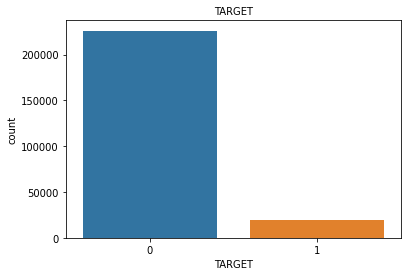

In [40]:
sns.countplot(data = df_application_train, x = 'TARGET')
plt.title("TARGET",fontsize=10)
plt.show()

**Base bastante desbalanceada**

#### Nome do acompanhante

In [ ]:
df_application_train['NAME_TYPE_SUITE'].value_counts()

https://towardsdatascience.com/too-much-data-too-little-time-1e7441ecdae1

<br>

## Estratégias para limpeza e tratamento dos dados

### Estratégia 1 - avaliar as colunas que são chave entre as tabelas

De acordo com os metadados as tabelas são ligadas pelas colunas:
- SK_ID_CURR;
- SK_ID_BUREAU;
- SK_ID_PREV.

Portanto podemos entender que essas colunas deverão ser mantidas.

### Estratégia 2 - Avaliar os dados faltantes

In [41]:
#Avaliando colunas com dados faltantes
df_application_train.isna().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         10
AMT_GOODS_PRICE                    226
NAME_TYPE_SUITE                   1048
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     162359
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [42]:
#Ordenando pelas colunas com mais dados faltantes
df_application_train.isna().sum().sort_values(ascending=False)

COMMONAREA_MEDI                 171978
COMMONAREA_AVG                  171978
COMMONAREA_MODE                 171978
NONLIVINGAPARTMENTS_MODE        170914
NONLIVINGAPARTMENTS_AVG         170914
NONLIVINGAPARTMENTS_MEDI        170914
FONDKAPREMONT_MODE              168392
LIVINGAPARTMENTS_MODE           168278
LIVINGAPARTMENTS_AVG            168278
LIVINGAPARTMENTS_MEDI           168278
FLOORSMIN_AVG                   166999
FLOORSMIN_MODE                  166999
FLOORSMIN_MEDI                  166999
YEARS_BUILD_MEDI                163680
YEARS_BUILD_MODE                163680
YEARS_BUILD_AVG                 163680
OWN_CAR_AGE                     162359
LANDAREA_MEDI                   146087
LANDAREA_MODE                   146087
LANDAREA_AVG                    146087
BASEMENTAREA_MEDI               144090
BASEMENTAREA_AVG                144090
BASEMENTAREA_MODE               144090
EXT_SOURCE_1                    138803
NONLIVINGAREA_MODE              135860
NONLIVINGAREA_AVG        

In [43]:
#Avaliando a porcentagem de dados faltantes nas colunas para eliminar colunas com pouca informação
col_faltantes = df_application_train.isna().sum().sort_values(
    ascending=False) / df_application_train.shape[0] * 100
col_faltantes

COMMONAREA_MEDI                 69.907483
COMMONAREA_AVG                  69.907483
COMMONAREA_MODE                 69.907483
NONLIVINGAPARTMENTS_MODE        69.474976
NONLIVINGAPARTMENTS_AVG         69.474976
NONLIVINGAPARTMENTS_MEDI        69.474976
FONDKAPREMONT_MODE              68.449807
LIVINGAPARTMENTS_MODE           68.403467
LIVINGAPARTMENTS_AVG            68.403467
LIVINGAPARTMENTS_MEDI           68.403467
FLOORSMIN_AVG                   67.883565
FLOORSMIN_MODE                  67.883565
FLOORSMIN_MEDI                  67.883565
YEARS_BUILD_MEDI                66.534422
YEARS_BUILD_MODE                66.534422
YEARS_BUILD_AVG                 66.534422
OWN_CAR_AGE                     65.997447
LANDAREA_MEDI                   59.383028
LANDAREA_MODE                   59.383028
LANDAREA_AVG                    59.383028
BASEMENTAREA_MEDI               58.571266
BASEMENTAREA_AVG                58.571266
BASEMENTAREA_MODE               58.571266
EXT_SOURCE_1                    56

In [44]:
col_faltantes_maior50 = col_faltantes[col_faltantes > 40]
col_faltantes_maior50

COMMONAREA_MEDI                 69.907483
COMMONAREA_AVG                  69.907483
COMMONAREA_MODE                 69.907483
NONLIVINGAPARTMENTS_MODE        69.474976
NONLIVINGAPARTMENTS_AVG         69.474976
NONLIVINGAPARTMENTS_MEDI        69.474976
FONDKAPREMONT_MODE              68.449807
LIVINGAPARTMENTS_MODE           68.403467
LIVINGAPARTMENTS_AVG            68.403467
LIVINGAPARTMENTS_MEDI           68.403467
FLOORSMIN_AVG                   67.883565
FLOORSMIN_MODE                  67.883565
FLOORSMIN_MEDI                  67.883565
YEARS_BUILD_MEDI                66.534422
YEARS_BUILD_MODE                66.534422
YEARS_BUILD_AVG                 66.534422
OWN_CAR_AGE                     65.997447
LANDAREA_MEDI                   59.383028
LANDAREA_MODE                   59.383028
LANDAREA_AVG                    59.383028
BASEMENTAREA_MEDI               58.571266
BASEMENTAREA_AVG                58.571266
BASEMENTAREA_MODE               58.571266
EXT_SOURCE_1                    56

#### Avaliando o conteúdo das colunas EXT_SOURCE_1,  WALLSMATERIAL_MODE, HOUSETYPE_MODE para supor a relevância para o modelo

In [45]:
df_application_train['EXT_SOURCE_1'].value_counts()

0.667740    5
0.546426    5
0.528197    5
0.300932    4
0.566862    4
           ..
0.396634    1
0.322740    1
0.261918    1
0.505461    1
0.362307    1
Name: EXT_SOURCE_1, Length: 94466, dtype: int64

Provavelmente essa coluna é uma pontuação atribuída por outra fonte e, pela quantidade de dados faltantes, possivelmente não agregará ao modelo.

In [46]:
df_application_train['WALLSMATERIAL_MODE'].value_counts()

Panel           52819
Stone, brick    51816
Block            7382
Wooden           4263
Mixed            1852
Monolithic       1427
Others           1285
Name: WALLSMATERIAL_MODE, dtype: int64

O material utilizado para construção da casa atual dos clientes possivelmente não é muito relevante ao modelo de predição de inadimplência. 

In [47]:
df_application_train['HOUSETYPE_MODE'].value_counts()

block of flats      120287
specific housing      1212
terraced house         969
Name: HOUSETYPE_MODE, dtype: int64

In [48]:
df_application_train['EMERGENCYSTATE_MODE'].value_counts()

No     127375
Yes      1872
Name: EMERGENCYSTATE_MODE, dtype: int64

O tipo da casa atual dos clientes possivelmente não é muito relevante ao modelo de predição de inadimplência. 

**Conclusão: excluir as colunas com mais de 40% dos dados faltantes.**

### Estratégia 3 - Avaliar os dados duplicados

In [49]:
df_application_train[df_application_train.duplicated() == True]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


In [50]:
#Confirmando se não existem dados duplicados
df_application_train.duplicated().sum()

0

**Não existem linhas com todos os dados duplicados.**

### Estratégia 4 - Ver colunas com forte correlação positiva ou negativa

In [51]:
df_application_train.corr()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.002557,-0.000077,-0.002651,0.000156,0.000057,0.000315,-0.000005,-0.002144,0.001836,...,0.000213,0.001389,0.000877,0.000714,-0.003660,-0.003445,0.003948,-0.000783,0.001091,0.004165
TARGET,-0.002557,1.000000,0.019246,-0.002286,-0.031103,-0.014100,-0.040060,-0.036342,0.079414,-0.044862,...,-0.008746,-0.002312,-0.000758,0.003712,0.000833,0.003549,-0.000118,-0.013337,-0.001611,0.021280
CNT_CHILDREN,-0.000077,0.019246,1.000000,0.012578,0.001899,0.021743,-0.002142,-0.022819,0.332396,-0.239866,...,0.003919,0.001337,0.002520,-0.001497,-0.000244,-0.000034,-0.002542,-0.009664,-0.012027,-0.041990
AMT_INCOME_TOTAL,-0.002651,-0.002286,0.012578,1.000000,0.142800,0.175158,0.145293,0.068520,0.025419,-0.058849,...,0.002815,0.002270,0.000302,-0.000856,0.000839,0.001767,0.002106,0.022914,0.004162,0.010191
AMT_CREDIT,0.000156,-0.031103,0.001899,0.142800,1.000000,0.769821,0.987024,0.101197,-0.055686,-0.064905,...,0.034726,0.021190,0.032827,-0.015101,-0.003954,0.004002,-0.002601,0.054316,0.017864,-0.049354
AMT_ANNUITY,0.000057,-0.014100,0.021743,0.175158,0.769821,1.000000,0.774900,0.119601,0.009139,-0.102962,...,-0.009436,0.004279,0.013219,-0.015980,0.003297,0.001617,0.012913,0.039495,0.012006,-0.013103
AMT_GOODS_PRICE,0.000315,-0.040060,-0.002142,0.145293,0.987024,0.774900,1.000000,0.104671,-0.053780,-0.062846,...,0.032844,0.020171,0.033589,-0.013603,-0.003033,0.004520,-0.002510,0.056240,0.018360,-0.052101
REGION_POPULATION_RELATIVE,-0.000005,-0.036342,-0.022819,0.068520,0.101197,0.119601,0.104671,1.000000,-0.029180,-0.004443,...,0.012261,0.002148,0.000558,0.000983,-0.003186,-0.001367,-0.003014,0.080857,-0.001373,0.001982
DAYS_BIRTH,-0.002144,0.079414,0.332396,0.025419,-0.055686,0.009139,-0.053780,-0.029180,1.000000,-0.616375,...,0.045166,0.003374,0.010069,0.024602,0.006319,0.002327,0.000077,0.002281,-0.015807,-0.073086
DAYS_EMPLOYED,0.001836,-0.044862,-0.239866,-0.058849,-0.064905,-0.102962,-0.062846,-0.004443,-0.616375,1.000000,...,-0.040025,-0.010516,-0.010067,-0.007813,-0.005171,-0.001137,0.002307,-0.035900,0.020817,0.050895


Muitos dados, não é possível avaliar o todo.

In [52]:
df_application_corr = df_application_train.corr()
df_application_corr[(df_application_corr > 0.9) & (df_application_corr < 1.0)]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TARGET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,NaN,0.987024,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,0.987024,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REGION_POPULATION_RELATIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_BIRTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_EMPLOYED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#Muito difícil visualizar
#plt.figure(figsize=(30,20))
#sns.heatmap(df_application_corr, annot=True, cmap=plt.cm.Reds)
#plt.show()

In [54]:
df_application_train.corr().sort_values('TARGET')

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
EXT_SOURCE_3,0.002684,-0.179246,-0.042886,-0.028683,0.043012,0.029117,0.047392,-0.007102,-0.204027,0.112342,...,-0.017289,-0.002265,-0.014922,-0.012592,-0.002373,-0.009843,-0.021793,-0.007124,-0.025224,-0.070242
EXT_SOURCE_2,0.001310,-0.160978,-0.017523,0.054826,0.131836,0.126699,0.139851,0.199326,-0.091906,-0.019764,...,0.001787,0.003890,0.003215,-0.006820,-0.004183,-0.000231,-0.000171,0.051359,-0.003711,-0.021358
EXT_SOURCE_1,0.001319,-0.158619,-0.140029,0.023339,0.168391,0.119544,0.175635,0.099948,-0.601492,0.289180,...,-0.029465,0.004585,-0.004208,-0.017924,-0.004723,-0.007274,-0.004628,0.032347,-0.006760,0.008499
DAYS_EMPLOYED,0.001836,-0.044862,-0.239866,-0.058849,-0.064905,-0.102962,-0.062846,-0.004443,-0.616375,1.000000,...,-0.040025,-0.010516,-0.010067,-0.007813,-0.005171,-0.001137,0.002307,-0.035900,0.020817,0.050895
FLOORSMAX_AVG,0.006101,-0.043720,-0.008682,0.054816,0.103929,0.130204,0.108795,0.322390,0.001114,-0.016487,...,0.009171,0.000258,-0.001772,-0.006246,0.003471,0.000859,0.001452,0.047402,-0.004367,-0.018679
FLOORSMAX_MEDI,0.005798,-0.043524,-0.008329,0.054358,0.103188,0.129063,0.108004,0.318070,0.001404,-0.016686,...,0.008964,0.000148,-0.001740,-0.006543,0.003813,0.000962,0.001417,0.046548,-0.004268,-0.018732
FLOORSMAX_MODE,0.005666,-0.042958,-0.008778,0.052553,0.100795,0.125970,0.105533,0.303837,0.001044,-0.015744,...,0.009493,0.000310,-0.001505,-0.006733,0.004230,0.001555,0.001682,0.044949,-0.003711,-0.018427
AMT_GOODS_PRICE,0.000315,-0.040060,-0.002142,0.145293,0.987024,0.774900,1.000000,0.104671,-0.053780,-0.062846,...,0.032844,0.020171,0.033589,-0.013603,-0.003033,0.004520,-0.002510,0.056240,0.018360,-0.052101
REGION_POPULATION_RELATIVE,-0.000005,-0.036342,-0.022819,0.068520,0.101197,0.119601,0.104671,1.000000,-0.029180,-0.004443,...,0.012261,0.002148,0.000558,0.000983,-0.003186,-0.001367,-0.003014,0.080857,-0.001373,0.001982
LIVINGAREA_AVG,0.003987,-0.033427,-0.010139,0.036229,0.072344,0.090262,0.077315,0.213680,-0.001612,-0.011923,...,0.004758,0.001473,-0.003399,-0.003757,0.005078,0.011396,-0.000309,0.037161,-0.006702,-0.019065


A correlação será feita após uma limpeza prévia para que possa ser analisada, pois o número de colunas impossibilita uma visão geral.

<br>

# Limpeza e tratamento das colunas

Após conhecer a base de dados que iremos trabalhar, iniciaremos o processo de limpeza e tratamento avaliado nas etapas anteriores.

## Criação da função com o pipeline para limpeza da base

Montaremos um pipeline para aplicar as transformações de forma organizada e replicável.

Passos a serem seguidos:<br>
1. Transformar a primeira coluna em index;<br>
2. Excluir colunas com mais de 40% dos dados faltantes;
3. Preencher dados numéricos com a média;
4. Preencher dados categóricos com o valor mais frequente;
5. Transformar as colunas categóricas em numéricas;<br>
    Conforme levantado na avaliação das colunas categóricas, transformar as colunas abaixo para numérica:
    - NAME_CONTRACT_TYPE - tipo de empréstimo - importante;
    - FLAG_OWN_CAR, FLAG_OWN_REALTY - se o cliente possui carro - importante, pode ser uma garantia;
    - NAME_INCOME_TYPE - tipo de renda do cliente - importante;
    - NAME_FAMILY_STATUS - status civil, pode ser importante;
    - NAME_HOUSING_TYPE - moradia atual, importante;
    - OCCUPATION_TYPE - tipo de ocupação profissional do cliente, importante;
    - ORGANIZATION_TYPE - tipo de organização onde o cliente trabalha, possivelmente manter;
    - FONDKAPREMONT_MODE?
    - HOUSETYPE_MODE?
    - EMERGENCYSTATE_MODE.

### Função que separa a base de treino e a base de teste:

In [55]:
def separa_treino_teste(df, col_target):
    
    '''
    Função para separar o dataset em treino e teste
    
    args:
    - df: dataset que será utilizado;
    - col_target: coluna que contém os resultados e será separada do dataset;
    
    return:
    - X_train: parte do dataset para treino sem a resposta (coluna target);
    - X_test: parte do dataset para teste sem a resposta (coluna target);
    - y_train: parte das linhas do dataset de treino com a resposta (coluna target);
    - y_test: parte das linhas do dataset de teste com a resposta (coluna target);
    '''
    
    # Separar a base de dados da resposta
    X = df.drop(labels=col_target, axis=1)
    y = df[col_target]

    # Dividir a base em treino e teste para evitar qualquer tipo de vazamento de dados
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    
    return X_train, X_test, y_train, y_test

In [56]:
# Testando a função de separação entre treino e teste
X_train, X_test, y_train, y_test = separa_treino_teste(df=df_application_train, col_target='TARGET')
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
37369,345657,Cash loans,F,N,Y,0,40500.0,265851.0,11839.5,229500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
153328,409596,Cash loans,F,Y,Y,0,270000.0,900000.0,26446.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
199441,446993,Cash loans,F,N,Y,1,90000.0,112068.0,11047.5,99000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
196546,237441,Cash loans,M,N,Y,0,202500.0,1125000.0,44743.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
204603,148978,Cash loans,F,N,Y,2,117000.0,101880.0,10206.0,90000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221541,394870,Cash loans,F,N,Y,2,180000.0,436032.0,34578.0,360000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
1407,131720,Cash loans,M,N,Y,0,90000.0,299772.0,11430.0,247500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
40785,409456,Cash loans,F,Y,Y,1,180000.0,269550.0,20988.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
80125,205969,Cash loans,F,N,N,0,112500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Criando as funções para excluir as colunas com dados faltantes:

In [57]:
def escolhe_col_mais_faltantes(df, limite_dados_faltantes):
    '''
    Função para selecionar as colunas que possuem mais de X(limite_dados_faltantes) 
    dados faltantes e monta um df com essas colunas

    args:
    - df: dataframe que será avaliado;
    - limite_dados_faltantes: porcentagem de dados faltantes a partir da qual a 
    coluna será excluída (ex: 40 = colunas com mais de 40% dos dados faltantes serão excluídas)

    return:
    - df_col_faltantes_X: dataframe contendo quais colunas serão excluídas
    '''

    # Ordenando os dados das colunas que mais possuem dados faltantes para as que menos possuem
    col_faltantes = df.isna().sum().sort_values(
        ascending=False) / df.shape[0] * 100

    # Porcentagem de dados faltantes acima da qual a coluna será excluída
    limite_dados_faltantes = limite_dados_faltantes

    # Seleção das colunas com mais de X(limite_dados_faltantes) dados faltantes
    lista_col_excluir = col_faltantes[col_faltantes > limite_dados_faltantes]

    # Tranformando em dataframe para que seja possível armazenar as colunas e as quantidades de dados faltantes
    df_col_faltantes_X = pd.DataFrame(lista_col_excluir)

    return df_col_faltantes_X

In [58]:
# Testando a função escolhe_col_mais_faltantes
df_col_application_train = escolhe_col_mais_faltantes(df_application_train, 40)
df_col_application_train

,0
COMMONAREA_MEDI,69.907483
COMMONAREA_AVG,69.907483
COMMONAREA_MODE,69.907483
NONLIVINGAPARTMENTS_MODE,69.474976
NONLIVINGAPARTMENTS_AVG,69.474976
NONLIVINGAPARTMENTS_MEDI,69.474976
FONDKAPREMONT_MODE,68.449807
LIVINGAPARTMENTS_MODE,68.403467
LIVINGAPARTMENTS_AVG,68.403467
LIVINGAPARTMENTS_MEDI,68.403467


In [59]:
# Função que fará a exclusão das colunas faltantes
def exclui_col_dados_faltantes(df, col_dados_faltantes):
    '''
    Função que excluirá as colunas que possuem X dados faltantes

    args: 
    - df: dataframe que será avaliado;
    - col_dados_faltantes: colunas com os dados faltantes que serão excluídas;

    return:
    - df sem as colunas com dados faltantes
    '''

    return df.drop(columns=col_dados_faltantes)

In [60]:
# Testando a função de excluir colunas
df_app_semColFaltante40 = exclui_col_dados_faltantes(
    df_application_train, df_col_application_train.index.tolist())
df_app_semColFaltante40

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,242114,0,Cash loans,F,N,Y,1,270000.0,1172470.5,34411.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
246004,452374,0,Cash loans,F,N,Y,0,180000.0,654498.0,27859.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
246005,276545,1,Revolving loans,M,N,N,1,112500.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246006,236776,1,Cash loans,M,Y,N,3,202500.0,204858.0,17653.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_app_semColFaltante40.shape

(246008, 73)

In [62]:
df_application_train.shape

(246008, 122)

Vamos excluir 49 colunas das 122 colunas existentes por causa da quantidade de dados faltantes (mais de 40%).

In [63]:
# Função que fará a exclusão das colunas faltantes
def exclui_col(df, colunas_excluir):
    '''
    Função que excluirá as colunas que possuem X dados faltantes

    args: 
    - df: dataframe que será avaliado;
    - colunas_excluir: colunas que serão excluídas;

    return:
    - df sem as colunas com dados faltantes
    '''

    return df.drop(columns=colunas_excluir)

Utilizando a função explicada no site: https://stackoverflow.com/questions/68402691/adding-dropping-column-instance-into-a-pipeline

In [64]:
#Classe de exclusão de missing para usar no pipeline

# class exclui_col_dados_faltantes():
#     '''
#     Classe para excluir colunas com dados faltantes
#     '''

#     def __init__(self, columns):
#         self.columns = columns

#     def transform(self, X, y=None):
#         return X.drop(self.columns, axis=1)

#     def fit(self, X, y=None):
#         return self

### Função para carregamento e limpeza da base

In [65]:
def pre_process_exclui_cols_dados_faltantes(arquivo, limite_dados_faltantes, index_col=None, encoding=None, excluir_cols=None):
    '''
        Função que faz o pré processamento dos dados:
        1. Carregamento do dataset e transformação da primeira coluna em index, quando necessário;
        2. Exclusão das colunas com mais de X% dos dados faltantes;
        3. Exclusão de colunas específicas escolhidas;
                
        args:
        - arquivo: nome do arquivo em csv que deverá ser carregado;
        - limite_dados_faltantes: porcentagem de dados faltantes que será usado como limite para exclusão de colunas;
        - index_col=None por padrão, ou pode indicar se alguma coluna será o índice (ex: 0);
        - encoding=None por padrão, ou pode indicar qual a codificação da base de dados (ex: Latin1);
        - excluir_cols: lista com o nome das colunas que deverão ser excluídas.
        
        return:
        - df com as colunas necessárias excluídas
    '''
    
    # Carregamento dos dados
    # ==========================================================
    df = carrega_dataset(arquivo=arquivo, index_col=index_col, encoding=encoding)
    
    
    # Excluir as colunas desnecessárias
    # ==========================================================
    #pipe_exclui_col_faltante = Pipeline([("exclui_col", exclui_col_dados_faltantes(df_col_faltantes_40.index.tolist()))])
    
    # Excluir as colunas avaliadas
    df.drop(excluir_cols, inplace=True, axis=1)
    
    # Excluir as colunas com mais de X% dos dados faltantes
    # Colunas que serão excluídas porque tem mais de X%(limite_dados_faltantes) dados faltantes
    df_col_exc = escolhe_col_mais_faltantes(df, limite_dados_faltantes)
    
    # df com as colunas com dados faltantes excluídas
    #df_semColFaltante = exclui_col_dados_faltantes(df, df_col_exc.index.tolist())
    df_semColFaltante = df.drop(columns=df_col_exc.index.tolist())
            
    return df_semColFaltante, df_col_exc

In [66]:
# Fazendo o pré processamento dos dados para aplicar os modelos - base principal de treino
# Limite de 40% de dados faltantes: mais do que 40% as colunas serão excluídas, pois
# teríamos mais dados adicionados do que dados reais
# Exclusão da coluna de gênero para evitar enviesamento do modelo
df, df_col_excluidas_dados_faltantes = pre_process_exclui_cols_dados_faltantes(application_train,
                                                                               40,
                                                                               index_col=0,
                                                                               encoding=None,
                                                                               excluir_cols=['CODE_GENDER'])

In [67]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
456162,0,Cash loans,N,N,0,112500.0,700830.0,22738.5,585000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
134978,0,Cash loans,N,N,0,90000.0,375322.5,14422.5,324000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
318952,0,Cash loans,Y,N,0,180000.0,544491.0,16047.0,454500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
361264,0,Cash loans,N,Y,0,270000.0,814041.0,28971.0,679500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
260639,0,Cash loans,N,Y,0,144000.0,675000.0,21906.0,675000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [68]:
# Lista com as colunas excluídas que tinham muitos dados faltantes
df_col_excluidas_app = df_col_excluidas_dados_faltantes.index.tolist()
df_col_excluidas_app

['COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'OWN_CAR_AGE',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_AVG',
 'ELEVATORS_MODE',
 'ELEVATORS_MEDI',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'ENTRANCES_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'LIVINGAREA_AVG',
 'HOUSETYPE_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION

### Avaliação de correlação entre duas colunas

Agora que a base possui menos colunas, tentativa de avaliar a correlação.

In [69]:
# Copia do df para manipulação do dataframe
df_corr = df.copy()

In [70]:
# Montando um dataframe com as correlações
df_corr = df_corr.corr()

In [71]:
# Filtrando o dataframe de correlação para apresentar apenas valores com muita correlação
# Valores maiores do que 0,9 (forte correlação direta) e menores do que -0,9 (forte correlação inversa)
df_muita_corr = df_corr[((df_corr > 0.9) & (df_corr < 1.0)) | 
                        ((df_corr < -0.9) & (df_corr > -1.0))]
df_muita_corr.dropna(how='all', inplace=True, axis=1)
df_muita_corr.dropna(how='all', inplace=True, axis=0)
df_muita_corr

,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
AMT_CREDIT,NaN,0.987024,NaN,NaN,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,0.987024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS_EMPLOYED,NaN,NaN,NaN,-0.99975,NaN,NaN,NaN,NaN
FLAG_EMP_PHONE,NaN,NaN,-0.99975,NaN,NaN,NaN,NaN,NaN
REGION_RATING_CLIENT,NaN,NaN,NaN,NaN,NaN,0.950801,NaN,NaN
REGION_RATING_CLIENT_W_CITY,NaN,NaN,NaN,NaN,0.950801,NaN,NaN,NaN
OBS_30_CNT_SOCIAL_CIRCLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998531
OBS_60_CNT_SOCIAL_CIRCLE,NaN,NaN,NaN,NaN,NaN,NaN,0.998531,NaN


In [72]:
# Montando um script para selecionar as colunas que possuem muita correlação
lista_corr = []

for i in df_muita_corr:
    for j in df_muita_corr:
        if not (np.isnan(df_muita_corr[i][j])):

            index_coluna = df_muita_corr[df_muita_corr[i]
                                         == df_muita_corr[i][j]].index.values
            index_linha = df_muita_corr[df_muita_corr[j]
                                        == df_muita_corr[i][j]].index.values

            lista_corr.append([index_coluna, index_linha])

lista_corr

[[array(['AMT_GOODS_PRICE'], dtype=object),
  array(['AMT_CREDIT'], dtype=object)],
 [array(['AMT_CREDIT'], dtype=object),
  array(['AMT_GOODS_PRICE'], dtype=object)],
 [array(['FLAG_EMP_PHONE'], dtype=object),
  array(['DAYS_EMPLOYED'], dtype=object)],
 [array(['DAYS_EMPLOYED'], dtype=object),
  array(['FLAG_EMP_PHONE'], dtype=object)],
 [array(['REGION_RATING_CLIENT_W_CITY'], dtype=object),
  array(['REGION_RATING_CLIENT'], dtype=object)],
 [array(['REGION_RATING_CLIENT'], dtype=object),
  array(['REGION_RATING_CLIENT_W_CITY'], dtype=object)],
 [array(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype=object),
  array(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype=object)],
 [array(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype=object),
  array(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype=object)]]

In [73]:
# Acessando a coluna para testar
print(lista_corr[0][0])

['AMT_GOODS_PRICE']


**Forte correlação positiva:**
- AMT_GOODS_PRICE e AMT_CREDIT = 0.987024
--> AMT_GOODS_PRICE: preço dos bens pelos quais o empréstimo é concedido;
--> AMT_CREDIT: valor do crédito do empréstimo;
- REGION_RATING_CLIENT e REGION_RATING_CLIENT_W_CITY = 0.950801	
--> REGION_RATING_CLIENT: nossa classificação da região onde o cliente mora;
--> REGION_RATING_CLIENT_W_CITY: nossa classificação onde o cliente mora levando em consideração a cidade;
- OBS_30_CNT_SOCIAL_CIRCLE e OBS_60_CNT_SOCIAL_CIRCLE = 0.998531	
--> OBS_30_CNT_SOCIAL_CIRCLE: quantas observações do ambiente social do cliente com padrão observável de 30 dias de atraso;
--> OBS_60_CNT_SOCIAL_CIRCLE: quantas observações do ambiente social do cliente com padrão observável de 60 dias de atraso;

**Forte correlação negativa:**
- FLAG_EMP_PHONE e DAYS_EMPLOYED = -0.99975
--> FLAG_EMP_PHONE: o cliente indicou telefone comercial/do trabalho (1 = sim/ 2 = não)
--> DAYS_EMPLOYED: quantos dias antes do pedido a pessoa começou no emprego atual

In [74]:
def colunas_muita_correlacao(df):
    
    # Copia do df para manipulação do dataframe
    df_corr = df.copy()
    
    # Montando um dataframe com as correlações
    df_corr = df_corr.corr()
    
    # Filtrando o dataframe de correlação para apresentar apenas valores com muita correlação
    # Valores maiores do que 0,9 (forte correlação direta) e menores do que -0,9 (forte correlação inversa)
    df_muita_corr = df_corr[((df_corr > 0.9) & (df_corr < 1.0)) | 
                            ((df_corr < -0.9) & (df_corr > -1.0))]
    df_muita_corr.dropna(how='all', inplace=True, axis=1)
    df_muita_corr.dropna(how='all', inplace=True, axis=0)
    df_muita_corr
    
    # Montando um script para selecionar as colunas que possuem muita correlação
    lista_corr = []

    for i in df_muita_corr:
        for j in df_muita_corr:
            if not (np.isnan(df_muita_corr[i][j])):

                index_coluna = df_muita_corr[df_muita_corr[i] == df_muita_corr[i][j]].index.values
                index_linha = df_muita_corr[df_muita_corr[j] == df_muita_corr[i][j]].index.values

                lista_corr.append([index_coluna,index_linha])
                
    return lista_corr

In [75]:
lista_corr = colunas_muita_correlacao(df)
lista_corr

[[array(['AMT_GOODS_PRICE'], dtype=object),
  array(['AMT_CREDIT'], dtype=object)],
 [array(['AMT_CREDIT'], dtype=object),
  array(['AMT_GOODS_PRICE'], dtype=object)],
 [array(['FLAG_EMP_PHONE'], dtype=object),
  array(['DAYS_EMPLOYED'], dtype=object)],
 [array(['DAYS_EMPLOYED'], dtype=object),
  array(['FLAG_EMP_PHONE'], dtype=object)],
 [array(['REGION_RATING_CLIENT_W_CITY'], dtype=object),
  array(['REGION_RATING_CLIENT'], dtype=object)],
 [array(['REGION_RATING_CLIENT'], dtype=object),
  array(['REGION_RATING_CLIENT_W_CITY'], dtype=object)],
 [array(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype=object),
  array(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype=object)],
 [array(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype=object),
  array(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype=object)]]

**MELHORIA DO CÓDIGO:** fazer uma função para selecionar apenas uma das colunas da correlação de forma automática.

### Avaliação de correlação com o target

In [76]:
df.corr().sort_values('TARGET')

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
EXT_SOURCE_3,-0.179246,-0.042886,-0.028683,0.043012,0.029117,0.047392,-0.007102,-0.204027,0.112342,-0.107729,...,-0.017289,-0.002265,-0.014922,-0.012592,-0.002373,-0.009843,-0.021793,-0.007124,-0.025224,-0.070242
EXT_SOURCE_2,-0.160978,-0.017523,0.054826,0.131836,0.126699,0.139851,0.199326,-0.091906,-0.019764,-0.058931,...,0.001787,0.003890,0.003215,-0.006820,-0.004183,-0.000231,-0.000171,0.051359,-0.003711,-0.021358
DAYS_EMPLOYED,-0.044862,-0.239866,-0.058849,-0.064905,-0.102962,-0.062846,-0.004443,-0.616375,1.000000,-0.211481,...,-0.040025,-0.010516,-0.010067,-0.007813,-0.005171,-0.001137,0.002307,-0.035900,0.020817,0.050895
AMT_GOODS_PRICE,-0.040060,-0.002142,0.145293,0.987024,0.774900,1.000000,0.104671,-0.053780,-0.062846,0.011648,...,0.032844,0.020171,0.033589,-0.013603,-0.003033,0.004520,-0.002510,0.056240,0.018360,-0.052101
REGION_POPULATION_RELATIVE,-0.036342,-0.022819,0.068520,0.101197,0.119601,0.104671,1.000000,-0.029180,-0.004443,-0.053035,...,0.012261,0.002148,0.000558,0.000983,-0.003186,-0.001367,-0.003014,0.080857,-0.001373,0.001982
AMT_CREDIT,-0.031103,0.001899,0.142800,1.000000,0.769821,0.987024,0.101197,-0.055686,-0.064905,0.009959,...,0.034726,0.021190,0.032827,-0.015101,-0.003954,0.004002,-0.002601,0.054316,0.017864,-0.049354
FLAG_DOCUMENT_6,-0.027750,-0.157104,-0.041791,-0.046133,-0.073169,-0.049514,0.000338,-0.406869,0.595253,-0.139660,...,-0.023161,-0.003992,-0.005727,-0.005276,-0.001717,0.002907,0.003602,-0.023321,0.013842,0.013369
FLAG_PHONE,-0.023610,-0.030148,0.000160,0.028638,0.012581,0.044407,0.090006,-0.043325,0.016213,-0.075382,...,0.001691,0.009409,0.000350,-0.001572,-0.004100,-0.000326,-0.001014,0.032710,-0.016838,-0.033132
HOUR_APPR_PROCESS_START,-0.023270,-0.007004,0.033583,0.053171,0.052607,0.062673,0.171538,0.093455,-0.092826,-0.009924,...,0.021212,0.001264,0.003532,0.002669,-0.015137,0.001740,-0.005731,0.037033,-0.005387,-0.032562
AMT_ANNUITY,-0.014100,0.021743,0.175158,0.769821,1.000000,0.774900,0.119601,0.009139,-0.102962,0.039346,...,-0.009436,0.004279,0.013219,-0.015980,0.003297,0.001617,0.012913,0.039495,0.012006,-0.013103


As colunas possuem fraca correlação com o TARGET, não serão necessárias alterações.

### Excluindo manualmente colunas

Colunas a excluir devido a forte correlação entre elas. Alguns algoritmos podem dar um peso maior para essas colunas enviesando o modelo.

Exclusão das colunas:
- AMT_GOODS_PRICE (coluna AMT_CREDIT será utilizada como equivalente);
- FLAG_EMP_PHONE (coluna DAYS_EMPLOYED será utilizada como equivalente);
- REGION_RATING_CLIENT_W_CITY (coluna REGION_RATING_CLIENT será utilizada como equivalente);
- OBS_60_CNT_SOCIAL_CIRCLE (coluna OBS_30_CNT_SOCIAL_CIRCLE será utilizada como equivalente).

In [77]:
# Atualizando a lista de colunas que foram excluídas do dataset para rastreabilidade 
# e aplicação do teste também

df_col_excluidas_app.extend(['AMT_GOODS_PRICE', 
                            'FLAG_EMP_PHONE', 
                            'REGION_RATING_CLIENT_W_CITY', 
                            'OBS_60_CNT_SOCIAL_CIRCLE'])
df_col_excluidas_app

['COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'OWN_CAR_AGE',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_AVG',
 'ELEVATORS_MODE',
 'ELEVATORS_MEDI',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'ENTRANCES_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'LIVINGAREA_AVG',
 'HOUSETYPE_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION

In [78]:
df.drop(labels = ['AMT_GOODS_PRICE',
                  'FLAG_EMP_PHONE',
                  'REGION_RATING_CLIENT_W_CITY',
                  'OBS_60_CNT_SOCIAL_CIRCLE'], 
        inplace=True, 
        axis=1)
df.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
456162,0,Cash loans,N,N,0,112500.0,700830.0,22738.5,Unaccompanied,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
134978,0,Cash loans,N,N,0,90000.0,375322.5,14422.5,Unaccompanied,Commercial associate,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
318952,0,Cash loans,Y,N,0,180000.0,544491.0,16047.0,Unaccompanied,Working,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
361264,0,Cash loans,N,Y,0,270000.0,814041.0,28971.0,Unaccompanied,Pensioner,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
260639,0,Cash loans,N,Y,0,144000.0,675000.0,21906.0,Unaccompanied,Working,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


### Montando o pipeline com as transformações

Optamos por fazer a exclusão das colunas com dados faltantes antes da divisão da base em treino e teste porque entendemos que não estamos extraindo métricas utilizando valores da porção que poderá ser de teste. Outro motivo é diminuir a quantidade de dados que será dividida e tratada, poupando esforço computacional para este caso.

In [79]:
def pipe_pre_process_transf(df, col_target):
    '''
        Função que faz o pré processamento dos dados:
        1. Preenchimento dos dados numéricos com a média;
        2. Preenchimento dados categóricos com o valor mais frequente;
        3. Transformar das colunas categóricas em numéricas.
        
        args:
        - df: dataset préviamente tratado (colunas desnecessárias retiradas)
        - col_target: string que contém o nome da coluna com a variável resposta;
       
        return:
        - pre_processador: pre_processador com os dados já alterados;
        - X_train: base de treino sem a resposta;
        - y_train: base de treino com a resposta;
        - X_test: base de teste sem a resposta;
        - y_test: base de teste com a resposta.
    '''
    
    # Separação entre treino e teste
    # ==========================================================
    X_train, X_test, y_train, y_test = separa_treino_teste(df, col_target)

    
    # Pré processamento dos dados numéricos e categóricos
    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                  ("onehot", OneHotEncoder())])

    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return pre_processador, X_train, y_train, X_test, y_test

In [80]:
# Fazendo o pré processamento dos dados para aplicar os modelos - base principal de treino
# Separação da coluna 'TARGET'
pre_processador, X_train, y_train, X_test, y_test = pipe_pre_process_transf(df,'TARGET')

In [81]:
# Avaliando o X_train para observar se as colunas foram excluídas
X_train

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,Cash loans,N,Y,0,40500.0,265851.0,11839.5,Family,Pensioner,Secondary / secondary special,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
409596,Cash loans,Y,Y,0,270000.0,900000.0,26446.5,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
446993,Cash loans,N,Y,1,90000.0,112068.0,11047.5,Family,Working,Secondary / secondary special,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
237441,Cash loans,N,Y,0,202500.0,1125000.0,44743.5,Unaccompanied,Working,Higher education,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
148978,Cash loans,N,Y,2,117000.0,101880.0,10206.0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,Cash loans,N,Y,2,180000.0,436032.0,34578.0,"Spouse, partner",Commercial associate,Secondary / secondary special,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
131720,Cash loans,N,Y,0,90000.0,299772.0,11430.0,Unaccompanied,Working,Secondary / secondary special,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
409456,Cash loans,Y,Y,1,180000.0,269550.0,20988.0,"Spouse, partner",Commercial associate,Secondary / secondary special,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [82]:
# Avaliando o conteúdo do y_train
y_train

SK_ID_CURR
345657    0
409596    0
446993    0
237441    0
148978    0
         ..
394870    1
131720    0
409456    0
205969    0
212369    0
Name: TARGET, Length: 172205, dtype: int64

In [83]:
# Avaliando o conteúdo do pre_processador
pre_processador

ColumnTransformer(transformers=[('transf_num',
                                 Pipeline(steps=[('input_num', SimpleImputer()),
                                                 ('std', StandardScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
                                  'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                  'FLAG_PHONE', 'FLAG_EMAI...
                                ('transf_cat',
                                 Pipeline(steps=[('input_cat',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                          

<br>

## Outliers

### Preenchendo os dados fora do pipeline para avaliação dos outliers

#### Colunas categóricas

In [84]:
# Criando um dataframe apenas com as variáveis categóricas
features_cat = X_train.select_dtypes(exclude=np.number)

In [85]:
# Preenchendo os dados faltantes das colunas categóricas com a palavra unknown
features_cat[:] = SimpleImputer(strategy='constant', fill_value='unknown').fit_transform(features_cat)
features_cat.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
SK_ID_CURR,,,,,,,,,,,
345657,Cash loans,N,Y,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,unknown,WEDNESDAY,XNA
409596,Cash loans,Y,Y,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,unknown,TUESDAY,Business Entity Type 3
446993,Cash loans,N,Y,Family,Working,Secondary / secondary special,Married,House / apartment,High skill tech staff,MONDAY,Business Entity Type 2
237441,Cash loans,N,Y,Unaccompanied,Working,Higher education,Civil marriage,House / apartment,Laborers,THURSDAY,Business Entity Type 3
148978,Cash loans,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,unknown,FRIDAY,Industry: type 3


In [86]:
# Checando se existem dados nulos
features_cat.isna().sum()

NAME_CONTRACT_TYPE            0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
dtype: int64

In [87]:
# Transformando as colunas categóricas em numéricas
X_train_cat = pd.get_dummies(features_cat)
X_train_cat.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
409596,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
446993,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
237441,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148978,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Colunas numéricas

In [88]:
features_num = X_train.select_dtypes(include=np.number)
features_num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,0,40500.0,265851.0,11839.5,0.031329,-21684,365243,-12509.0,-4789,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
409596,0,270000.0,900000.0,26446.5,0.010643,-17693,-2678,-8797.0,-1226,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
446993,1,90000.0,112068.0,11047.5,0.031329,-16691,-1291,-1392.0,-229,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
237441,0,202500.0,1125000.0,44743.5,0.028663,-21141,-2765,-6047.0,-4300,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
148978,2,117000.0,101880.0,10206.0,0.016612,-14488,-3223,-2221.0,-2375,1,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Preenchendo os dados faltantes das colunas numérica com a média
features_num[:] = SimpleImputer(strategy="mean").fit_transform(features_num)
features_num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,0.0,40500.0,265851.0,11839.5,0.031329,-21684.0,365243.0,-12509.0,-4789.0,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
409596,0.0,270000.0,900000.0,26446.5,0.010643,-17693.0,-2678.0,-8797.0,-1226.0,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
446993,1.0,90000.0,112068.0,11047.5,0.031329,-16691.0,-1291.0,-1392.0,-229.0,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
237441,0.0,202500.0,1125000.0,44743.5,0.028663,-21141.0,-2765.0,-6047.0,-4300.0,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
148978,2.0,117000.0,101880.0,10206.0,0.016612,-14488.0,-3223.0,-2221.0,-2375.0,1.0,...,0.0,0.0,0.0,0.0,0.006592,0.006934,0.034443,0.265409,0.263899,1.902101


In [90]:
# Checando se existem dados nulos
features_num.isna().sum()

CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
OBS_30_CNT_SOCIAL_CIRCLE       0
DEF_30_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
DAYS_LAST_PHONE_CHANGE         0
FLAG_DOCUMENT_2                0
FLAG_DOCUM

### Unindo os datasets de testes tranformados

In [91]:
X_train_num = features_num.copy()
X_train_num.head()
X_train_num_std = X_train_num.copy()

In [92]:
std = StandardScaler()
X_train_num_std[:] = std.fit_transform(X_train_num)
X_train_num_std

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,-0.578476,-1.148059,-0.827215,-1.053691,0.752479,-1.292502,2.131156,-2.137188,-1.189768,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,-0.313557,-4.651681e-01,-1.095587e+00
409596,-0.578476,0.909761,0.746463,-0.046883,-0.738425,-0.378315,-0.471239,-1.082877,1.168592,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,-0.313557,-4.651681e-01,-1.095587e+00
446993,0.809500,-0.704216,-1.208837,-1.108281,0.752479,-0.148794,-0.461429,1.020348,1.828509,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,-0.313557,-4.651681e-01,5.638856e-02
237441,-0.578476,0.304519,1.304814,1.214264,0.560333,-1.168122,-0.471855,-0.301801,-0.866098,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,-0.313557,-4.651681e-01,-5.195991e-01
148978,2.197476,-0.462119,-1.234119,-1.166282,-0.308221,0.355830,-0.475094,0.784889,0.408065,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,0.000000,0.000000,3.650385e-17,0.000000,-9.784819e-17,-3.836848e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,2.197476,0.102772,-0.404901,0.513593,1.825721,1.041414,-0.467045,-0.193302,-0.138666,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,0.867852,-4.651681e-01,3.512314e+00
131720,-0.578476,-0.704216,-0.743038,-1.081916,1.825721,-0.902180,-0.483907,-1.840379,-0.338561,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,-0.313557,-4.651681e-01,1.208364e+00
409456,0.809500,0.102772,-0.818036,-0.423118,0.711110,0.014756,-0.482429,0.697977,-2.061494,0.00241,...,-0.089814,-0.02312,-0.021827,-0.017546,-0.083334,-0.070376,-1.811972e-01,-0.313557,-4.651681e-01,6.323762e-01


<br>

### Avaliando os outliers através da distância interquartil

In [93]:
# Cálculo do 1º e do 3º quartil
Q1 = features_num.quantile(0.25)
Q3 = features_num.quantile(0.75)

# Cálculo do IQR
IQR = Q3 - Q1

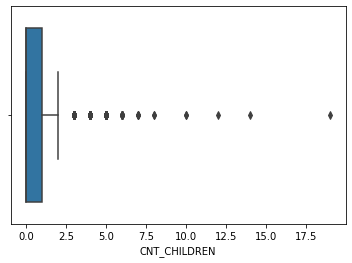

In [94]:
# Avalia do boxplot para comparação dos resultados observados
ax = sns.boxplot(x=features_num['CNT_CHILDREN'])

In [95]:
# Primeiro quartil: 0 filhos
Q1['CNT_CHILDREN']

0.0

In [96]:
# Terceiro quartil: 1 filho
Q3['CNT_CHILDREN']

1.0

In [97]:
# Distância entre o primeiro e terceiro quartil: 1 ponto
IQR['CNT_CHILDREN']

1.0

In [98]:
# Calculando o limite superior e inferior a partir do qual os dados serão considerados outliers
lim_superior = Q3 + 1.5 * IQR
lim_inferior = Q1 - 1.5 * IQR

In [99]:
# Limite acima do qual os dados serão considerados outliers: 2.5
lim_superior['CNT_CHILDREN']

2.5

In [100]:
# Limite abaixo do qual os dados serão considerados outliers: -1.5
lim_inferior['CNT_CHILDREN']

-1.5

In [101]:
# Filtrando o dataset para apresentar apenas os dados que estão fora dos limites estabelecidos
IQR_outliers = features_num[((features_num < lim_inferior) | (features_num > lim_superior))]
IQR_outliers

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,NaN,NaN,NaN,NaN,NaN,NaN,365243.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006592,0.006934,0.034443,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,8.0
131720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# Escolhendo uma coluna para avaliar os outliers
IQR_outliers['CNT_CHILDREN'].value_counts()

3.0     2031
4.0      238
5.0       48
6.0       11
7.0        4
10.0       2
8.0        2
14.0       1
12.0       1
19.0       1
Name: CNT_CHILDREN, dtype: int64

In [103]:
# Montando um dataframe sem outliers (valores fora foram transformados em nulos)
df_sem_outlier = features_num[~((features_num < lim_inferior) | (features_num > lim_superior))]
df_sem_outlier

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,0.0,40500.0,265851.0,11839.5,0.031329,-21684.0,NaN,-12509.0,-4789.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
409596,0.0,270000.0,900000.0,26446.5,0.010643,-17693.0,-2678.0,-8797.0,-1226.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
446993,1.0,90000.0,112068.0,11047.5,0.031329,-16691.0,-1291.0,-1392.0,-229.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.000000
237441,0.0,202500.0,1125000.0,44743.5,0.028663,-21141.0,-2765.0,-6047.0,-4300.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
148978,2.0,117000.0,101880.0,10206.0,0.016612,-14488.0,-3223.0,-2221.0,-2375.0,1.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.265409,0.263899,1.902101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,2.0,180000.0,436032.0,34578.0,0.046220,-11495.0,-2085.0,-5665.0,-3201.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,NaN
131720,0.0,90000.0,299772.0,11430.0,0.046220,-19980.0,-4469.0,-11464.0,-3503.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.000000
409456,1.0,180000.0,269550.0,20988.0,0.030755,-15977.0,-4260.0,-2527.0,-6106.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.000000


In [104]:
# Calculando qual a porcentagem da coluna com maior número de nulos
df_sem_outlier.isna().sum().max()/len(df_sem_outlier) * 100

26.133387532301615

O número de linhas que seriam excluídas caso optássemos por remover todas as linhas que contém outliers avaliados pelo IQR seria muito grande, podendo prejudicar a análise.

Dessa forma vamos remover as linhas que possuem muitos outliers.

In [106]:
# Fazendo a contagem de quantos nulos temos por linha
df_sem_outlier.isna().sum(axis = 1).value_counts()

2     37265
3     33200
1     31334
4     23223
0     16561
5     15036
6      8407
7      4065
8      1871
9       783
10      292
11      122
12       28
13       15
14        3
dtype: int64

In [107]:
# Excluindo linhas que tenham mais de 8 valores nulos (outliers) (55 - 47 = 8)
df_sem_outlier.dropna(inplace = True, axis = 0, thresh = 47)

In [ ]:
#################### Avaliar como excluir esses outliers do X_train e do y_train

<br>

# BASE LIMPA E TRATADA!

In [105]:
def metricas_classificacao(estimator):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))


    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

<br>

# Análise e exploração dos dados

### Select KBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('pre_processor', pre_processador),
                 ('selector', SelectKBest(mutual_info_classif, k=5)),
                 ('classifier', LogisticRegression())])

In [ ]:
pipe.fit(X_train, y_train)
pipe.predict(X_test)

In [ ]:
pipe = Pipeline([('pre_processor', pre_processador),
                 ('selector', SelectKBest(f_classif, k=10)),
                 ('classifier', LogisticRegression())])

In [ ]:
X_new = pipe.fit_transform(X_train, y_train)
pipe.predict(X_test)

In [ ]:
fs = SelectKBest(f_classif, k=10) # as k=10 features mais importantes. f_classif é a função score
X_new = fs.fit_transform(X_train, y_train) # o retorno é um array

print(f'Quantidade de features antes: {X_train.shape[1]}, quantidade de features depois {X_new.shape[1]}')

### Permutation importance

In [ ]:
from sklearn.inspection import permutation_importance

# Calcula o permutation_importance
result_perm = permutation_importance(estimator, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)

### Estratégia 5 - PCA

In [ ]:
from sklearn.decomposition import PCA

pipe_PCA = Pipeline([('pre_processador', pre_processador), ('pca', PCA())])
pipe_PCA.fit(X_train, y_train)
pipe_PCA.

<br>
<br>

**Passos:**

**Até quarta:**
- Pipeline na tabela principal:
-> Limpeza na tabela principal;
---> Valor faltante: 40%;
---> Excluir colunas desnecessárias;
---> Colunas categóricas - transformação para numérica;
---> Colunas com muita correlação - procurar como fazer, na visualização não tem como;
---> Remover outlier;
-> Feature selection - tentar usar os métodos das últimas aulas;
---> Filtro;
---> SelectKBest;
---> Permutation importance;
---> Otimização bayesiana;

**Até sábado:**
- Exploração
---> Dados que podemos cruzar com o target;
---> Describe;
---> Análise estatística em relação ao target;
- Execução do/dos modelos
-> Random Forest;
-> XGBoost;

- Relatório da estruturação do projeto e escolha do modelo

# Análise inicial de alguns modelos - base desbalanceada

Trata-se de um problema de classificação, dessa forma faremos testes inicias usando modelos de regressão logística.

## Baseline: regressão logística

In [108]:
pre_processador_base, X_train_base, y_train_base, X_test_base, y_test_base = pipe_pre_process_transf(df,'TARGET')

C:\Users\maeba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Métricas de avaliação de treino:
[[158099    127]
 [ 13872    107]]


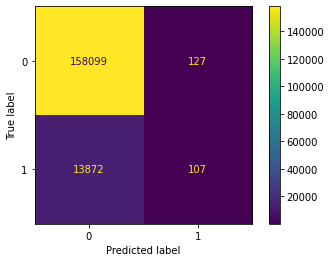

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    158226
           1       0.46      0.01      0.02     13979

    accuracy                           0.92    172205
   macro avg       0.69      0.50      0.49    172205
weighted avg       0.88      0.92      0.88    172205


Métricas de avaliação de teste:
[[67755    57]
 [ 5937    54]]


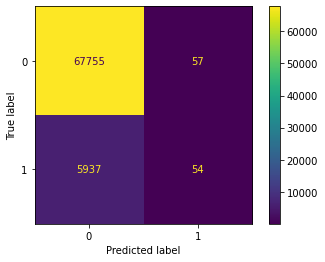

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67812
           1       0.49      0.01      0.02      5991

    accuracy                           0.92     73803
   macro avg       0.70      0.50      0.49     73803
weighted avg       0.88      0.92      0.88     73803



In [109]:
pipe_log = Pipeline([('pre_processador', pre_processador_base), ('log', LogisticRegression(random_state=42))])

# treinar o modelo
pipe_log.fit(X_train_base, y_train_base)

# avaliar o modelo
metricas_classificacao(pipe_log)

C:\Users\maeba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Métricas de avaliação de treino:
[[158109    117]
 [ 13875    104]]


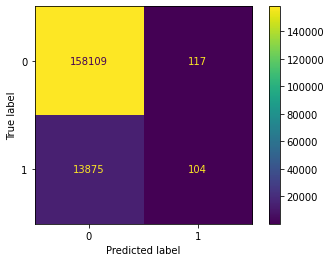

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    158226
           1       0.47      0.01      0.01     13979

    accuracy                           0.92    172205
   macro avg       0.69      0.50      0.49    172205
weighted avg       0.88      0.92      0.88    172205


Métricas de avaliação de teste:
[[67763    49]
 [ 5939    52]]


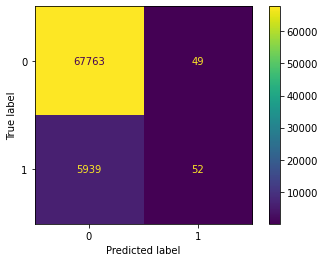

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67812
           1       0.51      0.01      0.02      5991

    accuracy                           0.92     73803
   macro avg       0.72      0.50      0.49     73803
weighted avg       0.89      0.92      0.88     73803



In [110]:
#Alterando o valor de C para que o algoritmo faça a conversão
pipe_log = Pipeline([('pre_processador', pre_processador_base), ('log', LogisticRegression(random_state=42, C=0.1))])

# treinar o modelo
pipe_log.fit(X_train_base, y_train_base)

# avaliar o modelo
metricas_classificacao(pipe_log)


Métricas de avaliação de treino:
[[158187     39]
 [ 13938     41]]


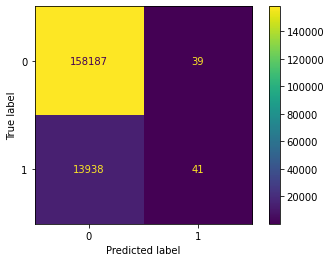

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    158226
           1       0.51      0.00      0.01     13979

    accuracy                           0.92    172205
   macro avg       0.72      0.50      0.48    172205
weighted avg       0.89      0.92      0.88    172205


Métricas de avaliação de teste:
[[67792    20]
 [ 5973    18]]


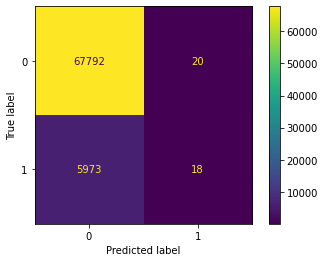

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67812
           1       0.47      0.00      0.01      5991

    accuracy                           0.92     73803
   macro avg       0.70      0.50      0.48     73803
weighted avg       0.88      0.92      0.88     73803



In [111]:
#Alterando o valor de C para que o algoritmo faça a conversão
pipe_log = Pipeline([('pre_processador', pre_processador_base), ('log', LogisticRegression(random_state=42, C=0.001))])

# treinar o modelo
pipe_log.fit(X_train_base, y_train_base)

# avaliar o modelo
metricas_classificacao(pipe_log)


Métricas de avaliação de treino:
[[158105    121]
 [ 13869    110]]


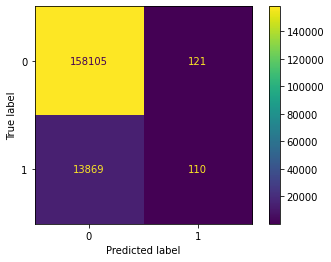

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    158226
           1       0.48      0.01      0.02     13979

    accuracy                           0.92    172205
   macro avg       0.70      0.50      0.49    172205
weighted avg       0.88      0.92      0.88    172205


Métricas de avaliação de teste:
[[67758    54]
 [ 5937    54]]


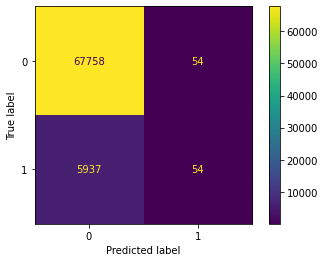

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67812
           1       0.50      0.01      0.02      5991

    accuracy                           0.92     73803
   macro avg       0.71      0.50      0.49     73803
weighted avg       0.89      0.92      0.88     73803



In [112]:
# Aumentando o número das iterações
pipe_log = Pipeline([('pre_processador', pre_processador_base),
                     ('log', LogisticRegression(random_state=42, max_iter=10000))])

# treinar o modelo
pipe_log.fit(X_train_base, y_train_base)

# avaliar o modelo
metricas_classificacao(pipe_log)

Foi necessário aumentar o número das iterações para o modelo convergir.

As métricas para a classe 0 foram boas, mas para a classe 1 foram bem ruins devido ao desbalanceamento (muito mais valores da classe 0)

### Excluindo colunas desnecessárias

In [113]:
df, df_col_excluidas_dados_faltantes = pre_process_exclui_cols_dados_faltantes(application_train,
                                                                               40,
                                                                               index_col=0,
                                                                               encoding=None,
                                                                               excluir_cols=['CODE_GENDER'])

## Regressão logística

In [114]:
pre_processador, X_train, y_train, X_test, y_test = pipe_pre_process_transf(df,'TARGET')


Métricas de avaliação de treino:
[[158095    131]
 [ 13848    131]]


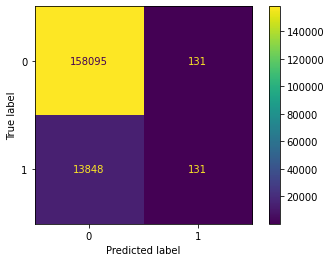

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    158226
           1       0.50      0.01      0.02     13979

    accuracy                           0.92    172205
   macro avg       0.71      0.50      0.49    172205
weighted avg       0.89      0.92      0.88    172205


Métricas de avaliação de teste:
[[67757    55]
 [ 5937    54]]


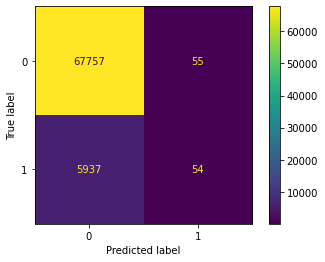

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67812
           1       0.50      0.01      0.02      5991

    accuracy                           0.92     73803
   macro avg       0.71      0.50      0.49     73803
weighted avg       0.89      0.92      0.88     73803



In [115]:
pipe_log_cols_excluidas = Pipeline(
    [('pre_processador', pre_processador), ('log', LogisticRegression(random_state=42, max_iter=10000))])

# treinar o modelo
pipe_log_cols_excluidas.fit(X_train, y_train)

# avaliar o modelo
metricas_classificacao(pipe_log_cols_excluidas)